**Importamos Librerías y fijando la semilla aleatoria**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import albumentations as A
from datetime import datetime

np.random.seed(123)
torch.manual_seed(0)

**Importamos el Dataset**

In [ ]:
df = pd.read_csv('fer2013.csv')
df['Usage'] = df['Usage'].astype('category')
df.head()

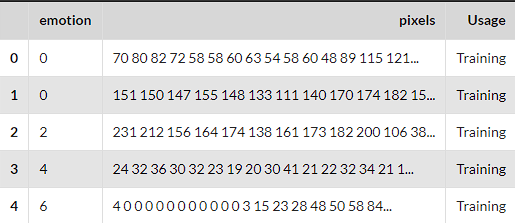

In [ ]:
df.dtypes

emotion       int64

pixels       object

Usage      category

dtype: object

Como se puede apreciar el dataset consiste de 3 columnas:

* **emotion**: Contiene la etiqueta que define la emoción de la imágen. (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
* **pixels**: Corresponden a los valores de cada uno de los pixeles. De acuerdo con las instrucciones de la competencia, las imágenes son de 48x48.
* **Usage**: Corresponde al set de datos correspondientes: Train, PublicTest, Private Test.

In [ ]:
df.Usage.value_counts().plot(kind = 'bar')
plt.title('Distribución de los Datos', fontsize = 20);

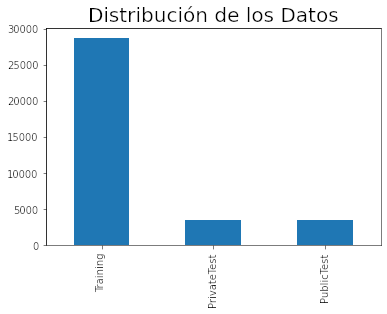

Como se puede ver, existen cerca de 28K imágenes que son utilizadas para entrenamiento. Todas estas imágenes contemplaban en la competencia una etiqueta por lo que podían ser utilizadas para entrenar.

Adicionalmente se pueden ver dos grupos, Public y Private Test que correspondían a los Sets de Validación. El set público era el que se usaba para evaluar los resultados al subirlos a la plataforma, mientras que el Private correspondía a los datos ocultos que se liberan sólo al finalizar la competencia para decidir a los ganadores.

**Cálculo de valores Nulos**

In [ ]:
df.isnull().sum()

emotion    0

pixels     0

Usage      0

dtype: int64


**Data Split y Pytorch Data Class**

Vamos entonces a dividir nuestro dataset en Train y Test, pero para Test utilizaremos ambos sets para determinar inmediatamente la performance de nuestro modelo.

In [ ]:
train_data = df.query('Usage == "Training"')[['emotion','pixels']]
test_data = df.query('Usage in ["PublicTest","PrivateTest"]')[['emotion','pixels']]
print(train_data.shape)
print(test_data.shape)

**Distribución de Labels**

Histograma de Emociones de Train

In [ ]:
train_data.emotion.hist();

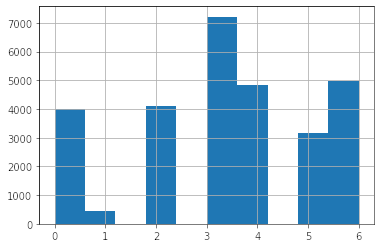

Histograma de Emociones de Test (Public + Private)

In [ ]:
test_data.emotion.hist();

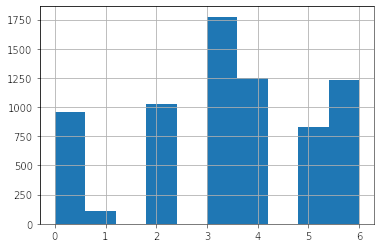


Podemos ver que las distribuciones son idénticas, muy probablemente este Test set fue generado siguiendo la misma distribución de etiquetas del Set de entrenamiento. Esto indica que la performance en nuestro set de entrenamiento debiera ser bastante similar a la del set de Test.

Para poder cargar los datos en Pytorch estos deben ser parte de un Dataset Class. Esta clase debe contener 3 propiedades:

* Un Constructor __init__(), con los parámetros para instanciar la clase,
* Un __len__ que permita contar el número de elementos de la clase.
* Un __getitem__ que permita extraer los datos de la clase. Adicionalmente, en que caso de que alguna transformación (Data Augmentation, Pre-Processing) deba aplicarse, esta es la etapa donde implementar esto.

In [ ]:
class EmoData(Dataset):
    def __init__(self, data, transform = None):
        self.data = data.reset_index(drop = True)
        self.transform = transform

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = np.array(self.data.pixels[idx].split(),
                        dtype = np.float32, copy = True).reshape(1,48,48)

        if self.transform is not None:
            image = self.transform(image = image)['image'].copy()
        label = np.array(self.data.emotion[idx])

        return {'image': torch.from_numpy(image),
               'label': torch.from_numpy(label)}

* La clase se construirá con un dataset (un pandas dataframe) y un Pipeline de transformaciones.
* El __len__ se realizará con un len().
* El __getitem__ tomará el string de pixeles de una fila, con split lo transformará en una lista para luego transformarlo en array de numpy de tamaño (1, 48,48) donde 1 es el canal (Blanco y Negro), y 48,48 es el tamaño. La razón por la que se transforma en un Numpy Array es porque haremos un poquito de Data Augmentation con Albumentations y esta librería espera esta estructura de dato.

Cabe destacar que se debe diferenciar una lógica cuando hay y cuando no hay transformaciones, para mayor robustez de la clase. Finalmente la salida serán tensores construidos desde numpy mediante torch.from_numpy().

Como Data Augmentations sólo aplicaremos un VerticalFlip, que permitirá invertir la foto y un Rotate, que permitirá de manera aleatoria rotar la imagen hasta en 22 grados con una probabilidad de 50% (de que se genere o no la rotación).

In [ ]:
transforms = A.Compose([
    A.VerticalFlip(p=0.25),
    A.Rotate(limit=22, p=0.5),
])

In [ ]:
data_train = EmoData(train_data, transform = transforms)
data_test = EmoData(test_data)

**Revisando los datos**

Mostraremos 10 emociones al azar.

In [ ]:
fig, ax = plt.subplots(1,10, figsize = (25,15))
for idx, value in enumerate(random_values):
    label = data_train[value]['label']
    img = data_train[value]['image'].numpy().transpose(1,2,0)
    ax[idx].imshow(img, cmap = 'gray')
    ax[idx].set_title(f'Emotion: {label}={emotions[label]}');

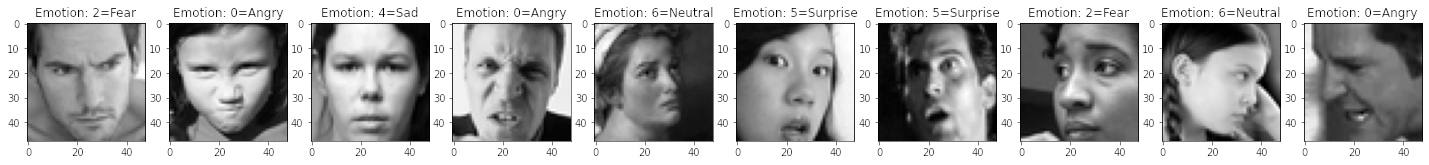

**DataLoaders**

Los DataLoaders son utilities provistos por Pytorch que nos permitirán cargar los datos de una manera más simple. Algunos aspectos a los que hay que poner atención:

* Se pueden incluir sólo elementos que sean clase Dataset, por eso el paso previo de transformar nuestros datos.
* Se debe definir el batch size dependiendo nuestra memoria RAM disponible en el caso de utilizar CPU, o del VRAM en caso de GPU. Si nuestra data no cabe en nuestra memoria el proceso explotará.
* **pin_memory** debe ser igual a True para pre alocar espacio en la GPU. Esto hará que el traspaso de CPU a GPU sea más eficiente.
* **num_workers** es la cantidad de núcleos que estarán encargados del proceso de cargar datos. Hay que recordar que el data augmentation se hace en CPU en Numpy, por lo tanto siempre habrá carga compartida entre CPU y GPU. He leído que librerías como Kornia permiten realizar el Data Augmentation directo en GPU, pero aún no la he probado, y por otro lado, Albumentations es por lejos la librería más popular en esta área.
* Sólo el dataset de entrenamiento debe ser shuffleado. Esto es importante ya que queremos que el modelo aprenda de manera aleatoria, no ordenado por clases. Cuando se trata de predecir cambiar de orden no afecta demasiado, por lo que no es necesario.

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = data_train,
                                            batch_size = batch_size,
                                            pin_memory = True,
                                            num_workers = 10,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = data_test,
                                            batch_size = batch_size,
                                            pin_memory = True,
                                            num_workers = 10,
                                            shuffle = False)

**Definición del Modelo**

Definiremos una arquitectura de Redes Convolucionales. Como se puede ver, cada capa Convolucional estará definida por:

* **Conv2d:** Encargada de sacar el mapa de características aplicando distintos filtros que permitan extraer patrones de la imagen.
* **Relu:** Será la función de activación no-lineal.
* **BatchNorm2d:** Corresponde a una estandarización de los resultados al salir de las capas. Esto asegura que el rango de datos siempre esté acotado evitando problemas de Vanishing o Exploiting Gradients en Redes muy profundas.
* **MaxPool2d:** Será la encargada de reducir la dimensión de la imagen. De esa manera las capas más profundas podrán detectar patrones más específicos.

In [ ]:
class CNN(nn.Module):
    def __init__(self, classes, channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2))

        # Cálculo del tamaño de salida de una Capa Convolucional
        # H_out = H_in + 2p - 2 --> p = 1 then H_out = H_in

        # Tamaños por capa.
        # 48 > 24 > 12 > 6

        self.fc1 = nn.Linear(128*6*6,1024) #n_channels * size
        self.fc2 = nn.Linear(1024, classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p = 0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = 0.2)
        x = self.fc2(x)
        return x

Algunos puntos importantes:
* Pytorch exige que nosotros calculemos el número de Neuronas de entrada a las Redes Densas, es decir cuando hacemos el proceso de Flatten del output de la sección convolucional. La manera más fácil de entenderlo es que será el número de canales de la capa convolucional (128, que es el número de filtros o feature maps generados), multiplicado por el tamaño de la imagen (6x6).
* Entre las capas Densas se agrega un dropout del 50% que generará desconexiones aleatorias de las neuronas. Esto servirá para regularizar permitiendo evitar overfitting.
* **x.size(0)** correponde al batch size que está siendo procesado. Por lo tanto hacer, un .view(x.size(0),-1) será equivalente a un Flatten manteniendo el batch size.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn = CNN(classes = 7, channels = 1).to(device)

In [ ]:
tensor_test = torch.randint(10, (1,1,48,48), dtype = torch.float32).to(device)
print(tensor_test.shape)
print(model_cnn(tensor_test).shape)

Si, por ejemplo, cargamos en el modelo un Tensor aleatorio de tamaño (1, 48,48) tal como espera la red, entonces obtendremos como salida un Tensor de (1,7) que equivale a las 7 clases involucradas en el proceso de entrenamiento.

**Definición del Modelo**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 3e-4)

In [ ]:
def train(epochs,
          model,
          train_loader = train_loader,
          test_loader = test_loader,
          criterion = criterion,
          optimizer = optimizer):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for batch in train_loader:
            inputs, targets = batch['image'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item()) # for every batch

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = batch['image'].to(device), batch['label'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        train_losses[epoch] = np.mean(train_loss)
        test_losses[epoch] = np.mean(test_loss)

        dt = datetime.now()-t0
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss : {train_losses[epoch]},
                Test Loss: {test_losses[epoch]}, Duration: {dt}')

    return train_losses, test_losses

train_losses, test_losses = train(100, model_cnn)

In [ ]:
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.title('Curva de Entrenamiento')
plt.legend()
plt.show()

**Evaluación**

In [ ]:
n_correct = 0.
n_total = 0.
model_cnn.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch['image'].to(device), batch['label'].to(device)

        outputs = model_cnn(inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    test_acc = n_correct / n_total
test_acc

0.6213429924770131

El resultado es bastante optimista. En un primer intento se obtuvo un 0.6213. Lo cual nos hubiera ubicado en el 11vo lugar, obteniendo una medalla de Plata. A pesar de eso pensé que sería un problema más sencillo al tener imágenes de baja resolución y con distribuciones similares en train y test.

**Cómo mejorar el Modelo**
Debido a que estamos utilizando sólo redes convolucionales ordinarias el espectro de mejora es bastante. A pesar de ser imágenes pequeñas resultó ser un problema que no generaliza tan bien. Algunas cosas para tomar en cuenta en el futuro y mejorar:

* **Optimización de Hiperparámetros:** Los valores que estamos usando son sólo valores estándar y no necesariamente los óptimos para el problema. Realizando algún proceso de tuning podríamos lograr mejores resultados. Me da la impresión que la parte de redes densas está muy compleja y hay demasiadas neuronas por lo que reduciendo el número de parámetros y/o aplicando una regularización más agresiva podría generar un aumento significativo en la performance.

* **Arquitecturas más modernas:** Obviamente en ese tiempo no existían arquitecturas como EfficientNets o ViT, por lo que me da la impresión que podrían fácilmente mejorar la performance en este tipo de problemas.
Transfer learning: Combinar esta estrategia con arquitecturas del punto anterior debiera entregar mejores resultados.

* **Callbacks:** Siento que alterar el batch_size y el learning rate debiera ayudar. Mi intención era utilizar un batch_size pequeño ya que quería probar como andaba la RTX 2070. Siento que logra buenos tiempos de entrenamiento sin tener problemas de memoria. Acá pienso probar en el futuro utilizando Pytorch Lightning que entrega muchas más opciones de callbacks como early stopping y cambios en el learning rate a medida que se entrena.

* **Balance de clases:** Como se vió al inicio, este dataset tiene un problema de desbalance. Existen muchos más ejemplares de la clase 3 (Happy) y muy poquitos de la clase 1 (Angry) por lo que esto puede impactar negativamente en los resultados. Además al hacer una inspección manual de los datos se puede ver que emociones de miedo, triteza y neutral son bien parecidos y debe ser dificil para la red de identificar.